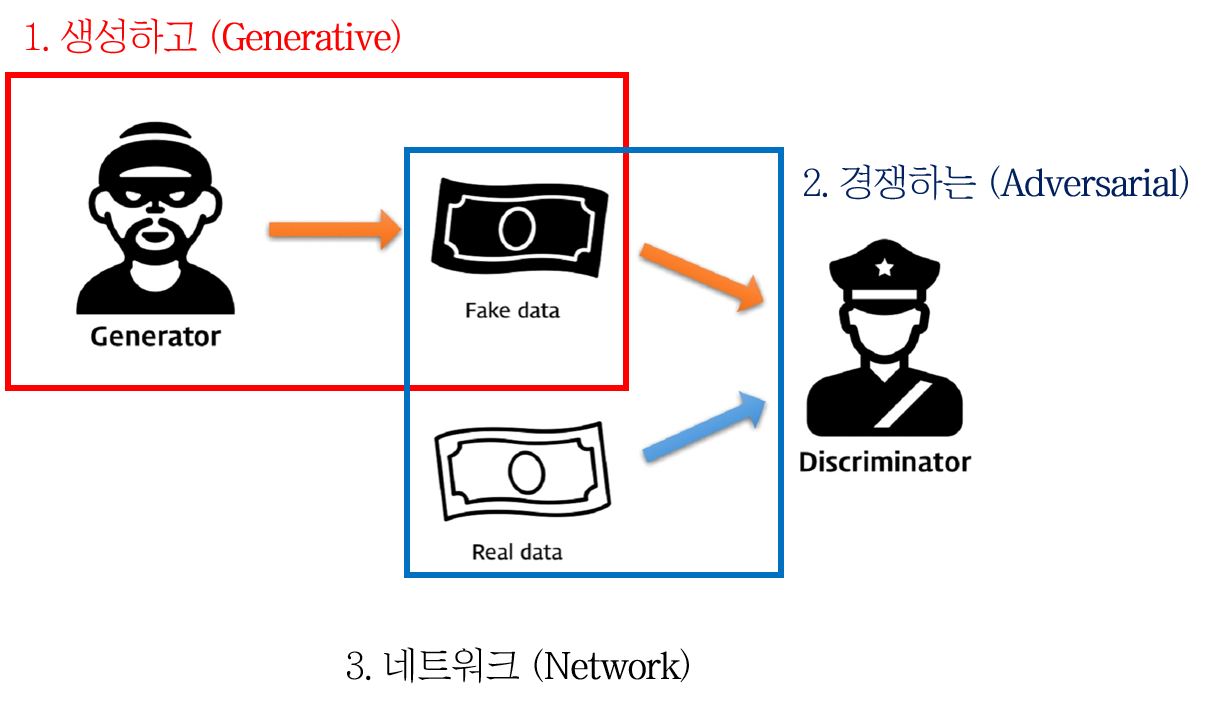

In [22]:
# noise data ( 아무 의미 없는) -> mnist 데이터 생성
# Generator 목적 -> Discriminator(판별자) 완벽하게 속이는게 목표
# Discriminator는 완벽하게 판단하는게 목표

In [23]:
import os 
import time
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import PIL

mnist = tf.keras.datasets.mnist
#test 데이터는 굳이 필요없음. 
(x_train,y_train), (_ , _) = mnist.load_data()

In [24]:
#이미지 한개는 28x28
x_train.shape

(60000, 28, 28)

In [25]:
x_train.shape

(60000, 28, 28)

In [26]:
x_train =  x_train.reshape(x_train.shape[0],28,28,1).astype('float32')
#-1~ 1로 전처리, 0~1값 대비 표현할 수 있는 범위가 공학적으로 2배 되었다.
# 실제로 소수는 무한대지만, 컴퓨터 비트연산의 한계로 2배가 도리 수 있다.
x_train = (x_train - 127.5) / 127.5

In [27]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(80000).batch(128)
#shuffle(버퍼 사이즈 GPU에 들어가기- 모델에 들어가기전 메모리에 준비해놓는 공간을 8만 만큼 하겠다)

In [28]:
def make_generator():
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(128, activation = 'relu',
                           input_shape=(100,)))
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(28*28,activation='tanh'))
    model.add(layers.Reshape((28,28,1)))
    
    return model


In [29]:
def make_dicriminator():
    model = tf.keras.models.Sequential()
    model.add(layers.Flatten(input_shape=(28,28,1)))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dense(128, activation = 'relu'))
    model.add(layers.Dense(1 , activation='sigmoid'))
    return model

In [30]:
#discriminator를 속이는게 목표.
generator = make_generator()
print(type(generator))
#진위 판별의 목적
discriminator = make_dicriminator()

<class 'keras.engine.sequential.Sequential'>


In [31]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [32]:
#모두 참이라고 계산해야함.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [33]:
#각각에 대해서 1,0 으로 해야함.
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss+fake_loss
    return total_loss

In [34]:
#각각 옵티마이저 따로 만들기
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0001)

In [35]:
#텐서플로우 내부적 연산시키는 매직키워드
@tf.function
def train_step(images):
    #100차원의 벡터 128개 생성
    noise = tf.random.normal([128, 100])
    #GradientTape: 각 Gradient를 기록하는 메소드
    # x축인 weight 값과 y축인 Loss 값을 기록한다.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise)

        fake_output = discriminator(generated_image)
        real_output = discriminator(images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, 
                                                    discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                        generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                            discriminator.trainable_variables))

In [36]:
import matplotlib.pyplot as plt
def generate_save_show(model, epoch, test_input):

    prediction = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.imshow(prediction[i, :,:, 0] * 127.5 + 127.5)
        plt.axis('off')
    ㄴ
    plt.savefig(f'epoch_image_{epoch}.png')
    plt.show()

In [37]:
seed = tf.random.normal([16, 100])
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:

            train_step(image_batch)

        if epoch % 5 == 0:
            generate_save_show(generator, epoch + 1, seed)
        print(f'epoch {epoch} , {time.time() - start}')
    
    generate_save_show(generator, epochs, seed)

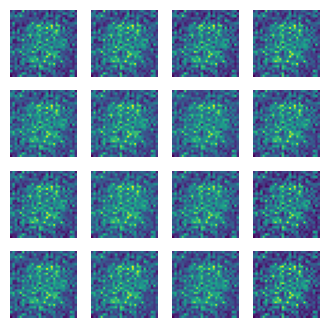

epoch 0 , 13.665189027786255
epoch 1 , 8.884664058685303
epoch 2 , 8.545000076293945


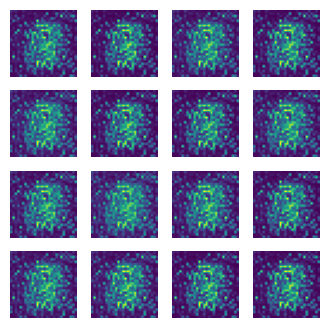

In [38]:
train(x_train, 3)